# Sorted cell validation 
* Here I'm reading in the sorted cell data and generating Figure 3

In [1]:
import os 
if os.getcwd().endswith('Validation'):
    os.chdir('..')

In [4]:
import NotebookImport
from IPython.display import clear_output
from Setup.Imports import *
from Setup.MethylationAgeModels import *
from Validation.Process_Clinical import *
clear_output()

In [5]:
path = '/cellar/users/agross/TCGA_Code/Methlation/data/Validation/'

In [6]:
data_horvath = pd.read_csv(path + 'BMIQ_Horvath.csv', index_col=0)
data_hannum = pd.read_csv(path + 'BMIQ_Hannum2.csv', index_col=0)
cell_type = cell_type.ix[data_horvath.columns]

#### Create generic plot for showing age advancment

In [9]:
control_color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
hiv_color = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

def model_plot(prediction):
    fig, axs = subplots(1,3, figsize=(14,4),sharey=False)
    plot_regression(age, prediction.ix[ti(hiv=='HIV-')], ax=axs[0], 
                   color=control_color, alpha=1, edgecolor='black', s=30, 
                   line_args=[{'color':'grey','alpha':1, 'ls':'--'},
                              {'alpha':0}])
    plot_regression(age, prediction.ix[ti(hiv=='HIV+')], ax=axs[1], 
                    color=hiv_color, alpha=1, edgecolor='black', s=30, 
                    line_args=[{'color':hiv_color,'alpha':1, 'ls':'-'},
                               {'alpha':1, 'color':'grey', 'ls':'--'}])
    axs[0].set_title('HIV-')
    axs[1].set_title('HIV+')

    for ax in axs[[0,1]]:
        ax.set_xlim(20,75)
        ax.set_ylim(20,75)
        
    ax = axs[2]
    zscore = lambda s: (s - s.mean()) / s.std()
    residual = prediction - age
    e2 = residual.groupby(hiv).apply(zscore)
    sns.violinplot(residual[e2.abs() < 3], hiv, ax=ax, 
                   order=['HIV-','HIV+'],
                   inner='points', inner_kws={"ms": 8}, alpha=.5,
                   bw='scott', cut=0, color=[control_color,
                                             hiv_color, hiv_color])
    x = hiv.map({'HIV-':1, 'HIV+':2})
    series_scatter(x, residual[e2.abs() > 3], color='white', edgecolor='red',
                   alpha=1, s=20, lw=1, ax=ax, ann=None)
    ax.set_ylabel('Biological Age - Chronological Age')
    ax.set_xlabel('')
    prettify_ax(ax)
    fig.tight_layout()

### Running methylation age models

Horvath model in neutrophils

In [8]:
pred_horvath = run_horvath_model(data_horvath.ix[:, ti(cell_type == 'Neu')])
reg = linear_regression(age, pred_horvath.ix[ti(hiv=='HIV-')])
pred_horvath_adj = (pred_horvath - reg['intercept']) / reg['slope']
horvath_neu = pred_horvath_adj

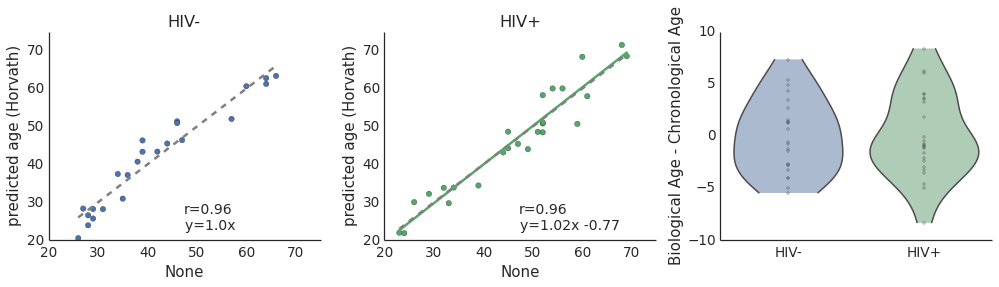

In [10]:
model_plot(horvath_neu)

Horvath model in CD4+ t-cells

In [11]:
pred_horvath = run_horvath_model(data_horvath.ix[:, ti(cell_type == 'CD4')])
reg = linear_regression(age, pred_horvath.ix[ti(hiv=='HIV-')])
pred_horvath_adj = (pred_horvath - reg['intercept']) / reg['slope']
horvath_cd4 = pred_horvath_adj

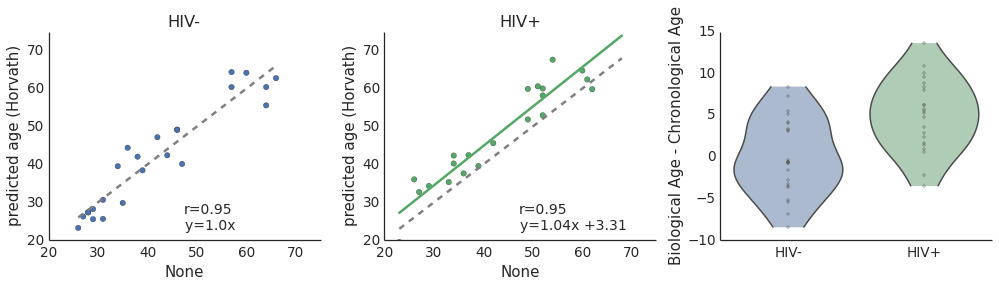

In [12]:
model_plot(pred_horvath_adj)

Hannum model in neutrophils

In [13]:
pred_hannum = run_hannum_model(data_hannum.ix[:, ti(cell_type == 'Neu')])
reg = linear_regression(age, pred_hannum.ix[ti(hiv=='HIV-')].dropna())
pred_hannum_adj = (pred_hannum - reg['intercept']) / reg['slope']
hannum_neu = pred_hannum_adj

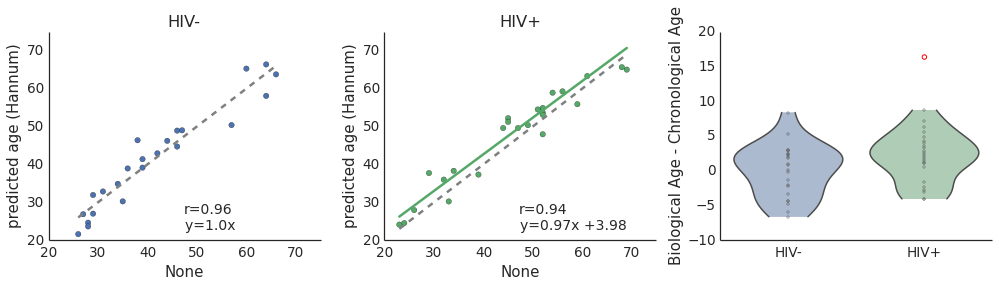

In [14]:
model_plot(pred_hannum_adj)

Hannum model in CD4+ t-cells

In [15]:
pred_hannum = run_hannum_model(data_hannum.ix[:, ti(cell_type == 'CD4')])
reg = linear_regression(age, pred_hannum.ix[ti(hiv=='HIV-')].dropna())
pred_hannum_adj = (pred_hannum - reg['intercept']) / reg['slope']
hannum_cd4 = pred_hannum_adj

(-10, 20)

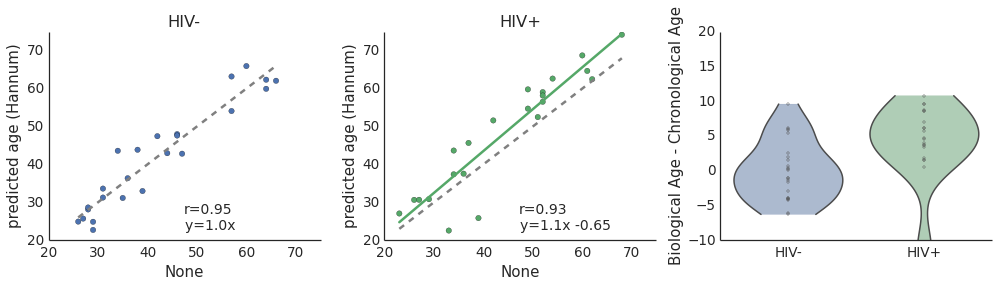

In [16]:
model_plot(pred_hannum_adj)
plt.gcf().axes[2].set_ylim(-10,20)

Consensus model in neutrophils

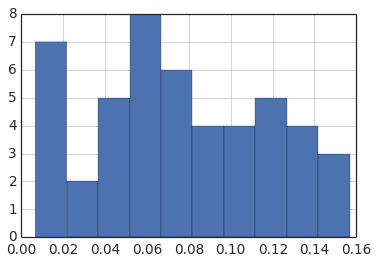

In [19]:
diff = ((hannum_neu - horvath_neu) / ((hannum_neu + horvath_neu) * .5)).abs()
diff = diff.groupby(level=0).first()
diff.name = 'Absolute difference in models'
diff_neu = diff
diff.hist()

In [20]:
pred_c = (hannum_neu + horvath_neu) / 2.
reg = linear_regression(age, pred_c.ix[ti(hiv=='HIV-')])
pred_c_adj = (pred_c - reg['intercept']) / reg['slope']
pred_c_adj = pred_c_adj
pred_c_adj_neu = pred_c_adj

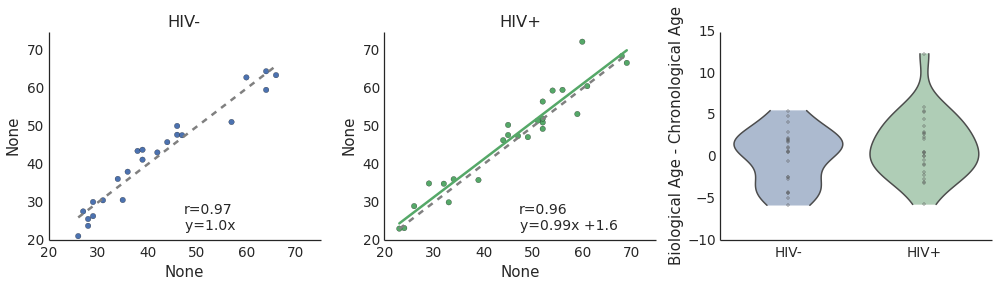

In [21]:
model_plot(pred_c_adj)

Consensus model in CD4+ t-cells

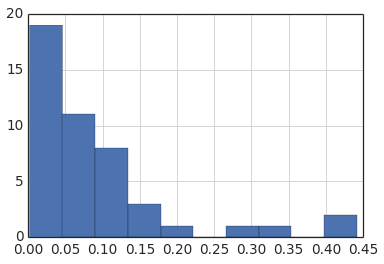

In [22]:
diff = ((hannum_cd4 - horvath_cd4) / ((hannum_cd4 + horvath_cd4) * .5)).abs()
diff = diff.groupby(level=0).first()
diff.name = 'Absolute difference in models'
diff_cd4 = diff
diff.hist()

In [23]:
pred_c = (hannum_cd4 + horvath_cd4) / 2.
reg = linear_regression(age, pred_c.ix[ti(hiv=='HIV-')])
pred_c_adj = (pred_c - reg['intercept']) / reg['slope']
pred_c_adj = pred_c_adj.ix[ti(diff_cd4 < .3)]
pred_c_adj_cd4 = pred_c_adj

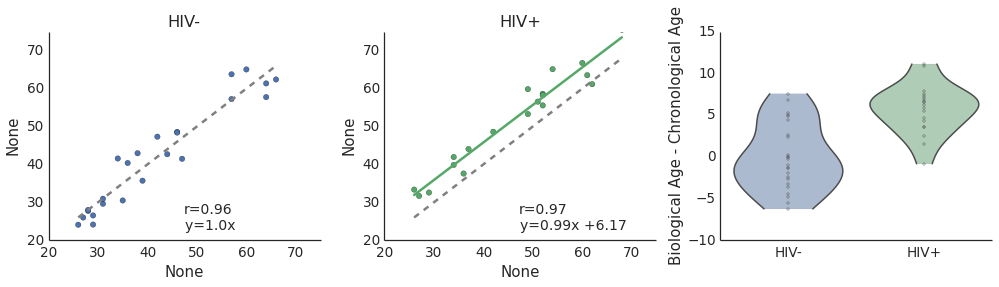

In [24]:
model_plot(pred_c_adj)

In [38]:
dd = pd.concat({'CD4':diff_cd4, 'Neu': diff_neu}).reset_index()
dd = dd[['level_0','Absolute difference in models']]

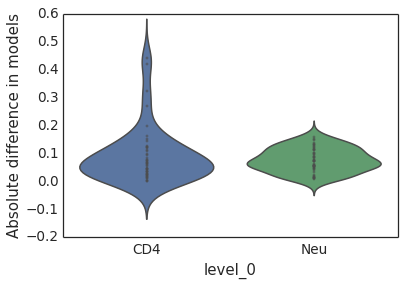

In [42]:
sns.violinplot(dd['Absolute difference in models'], groupby=dd['level_0'],
               inner='points')

Read in unsupervised analysis from other notebook.

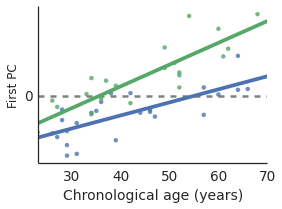

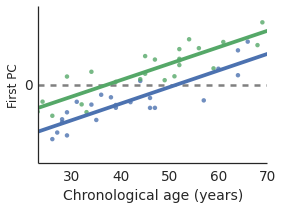

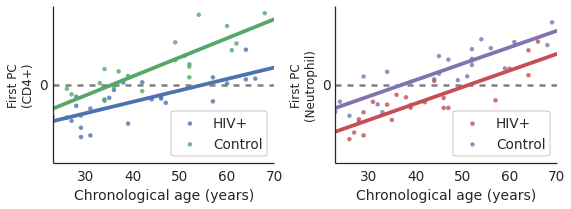

In [43]:
import Validation.Unsupervised_both as PCA
clear_output()

Tweaking the model plot a bit for the final figure. 

In [25]:
control_color = (0.2980392156862745, 0.4470588235294118, 0.6901960784313725)
hiv_color = (0.3333333333333333, 0.6588235294117647, 0.40784313725490196)

def model_plot(prediction, axs):
    plot_regression(age, prediction.ix[ti(hiv=='HIV-')], ax=axs[0], 
                   color=control_color, alpha=1, edgecolor='black', s=30, 
                   line_args=[{'color':'grey','alpha':1, 'ls':'--'},
                              {'alpha':0}])
    ann = axs[0].get_children()[4]
    ann.set_text(ann.get_text().split()[0])
    ann.set_fontsize(16)

    plot_regression(age, prediction.ix[ti(hiv=='HIV+')], ax=axs[1], 
                    color=hiv_color, alpha=1, edgecolor='black', s=30, 
                    line_args=[{'color':hiv_color,'alpha':1, 'ls':'-'},
                               {'alpha':1, 'color':'grey', 'ls':'--'}])

    for ax in axs[[0,1]]:
        ax.set_xlim(20,77)
        ax.set_ylim(20,77)
        ax.set_xlabel('Chronological age (years)')
        
    ax = axs[2]
    zscore = lambda s: (s - s.mean()) / s.std()
    residual = prediction - age
    e2 = residual.groupby(hiv).apply(zscore)

    sns.violinplot(residual[e2.abs() < 3], hiv, ax=ax, 
                   order=['HIV-','HIV+'],
                   inner='points', inner_kws={"ms": 8}, alpha=.5,
                   bw='scott', cut=0, color=[control_color,
                                             hiv_color, hiv_color])
    x = hiv.map({'HIV-':1, 'HIV+':2})
    series_scatter(x, residual[e2.abs() > 3], color='white', edgecolor='red',
                   alpha=1, s=20, lw=1, ax=ax, ann=None)
    ax.set_ylabel('Age advancemnt')
    ax.set_xlabel('')

    prettify_ax(ax)

#### Generate final figure

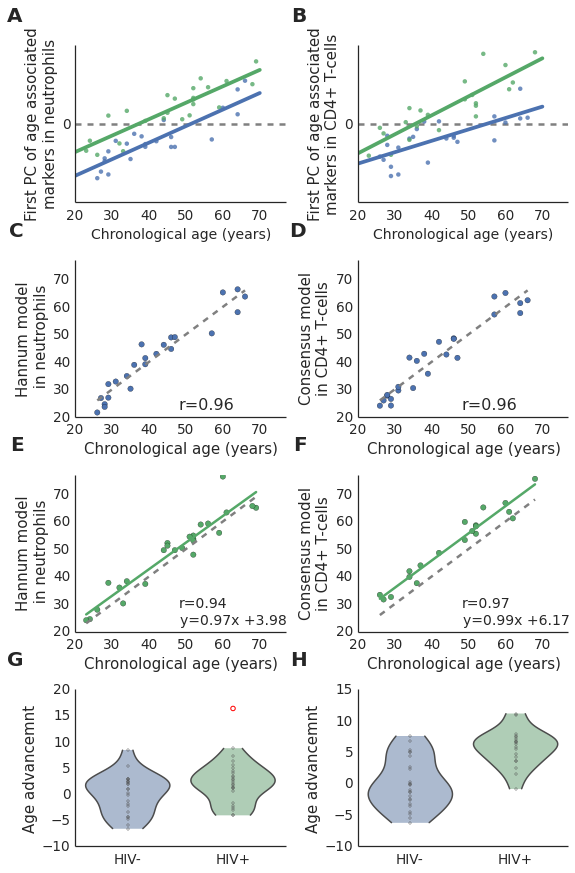

In [32]:
fig, axs = subplots(4,2, figsize=(8,12))
pred_c_adj_cd4.name = 'Consensus model\nin CD4+ T-cells'
model_plot(pred_c_adj_cd4, axs[1:,1])

hannum_neu.name = 'Hannum model\n in neutrophils'
model_plot(hannum_neu, axs[1:,0])

ax = axs[0][1]
sns.regplot(*match_series(PCA.age, PCA.rr1.ix[ti(PCA.hiv==0)]),
            ax=ax, label='HIV+', ci=None, color=control_color)
sns.regplot(*match_series(PCA.age, PCA.rr1.ix[ti(PCA.hiv>0)]),
            ax=ax, label='Control', ci=None, color=hiv_color)
ax.set_ylabel('First PC of age associated\nmarkers in CD4+ T-cells')

ax = axs[0][0]
sns.regplot(*match_series(PCA.age, PCA.rr2.ix[ti(PCA.hiv==0)]),
            ax=ax, label='HIV+', ci=None, color=control_color)
sns.regplot(*match_series(PCA.age, PCA.rr2.ix[ti(PCA.hiv>0)]),
            ax=ax, label='Control', ci=None, color=hiv_color)
ax.set_ylabel('First PC of age associated\nmarkers in neutrophils')

for ax in axs[0]:
    #ax.legend(loc='lower right', frameon=True, fancybox=True)
    ax.set_xlabel('Chronological age (years)', size=14)

    ax.set_yticks([0])
    ax.axhline(0, ls='--', lw=2.5, color='grey', zorder=-1)
    ax.set_xbound(20,77)
    prettify_ax(ax)

letters = list(map(chr, range(97, 123)))[:8] 
for i,ax in enumerate(axs.flatten()):
    ax.text(-0.25, 1.25, letters[i].upper(), transform=ax.transAxes,
            fontsize=20, fontweight='bold', va='top', ha='right')
fig.tight_layout()
fig.savefig(FIGDIR + 'sorted_validation.pdf')